# Neural Network Classification on Iris

Writer: E.W

Date: 2024.05.19

In [1]:
%load_ext lab_black

## Data Preparation

In [2]:
import pandas as pd
from sklearn.utils import shuffle

df = pd.read_csv("DataSet/Iris.csv")
df.drop(["Id"], axis=1, inplace=True)
df.rename(columns={"Species": "y"}, inplace=True)
df.y.replace(
    ["Iris-setosa", "Iris-versicolor", "Iris-virginica"], [0, 1, 2], inplace=True
)
df = shuffle(df, random_state=42).reset_index(drop=True)
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,y
0,6.1,2.8,4.7,1.2,1
1,5.7,3.8,1.7,0.3,0
2,7.7,2.6,6.9,2.3,2
3,6.0,2.9,4.5,1.5,1
4,6.8,2.8,4.8,1.4,1


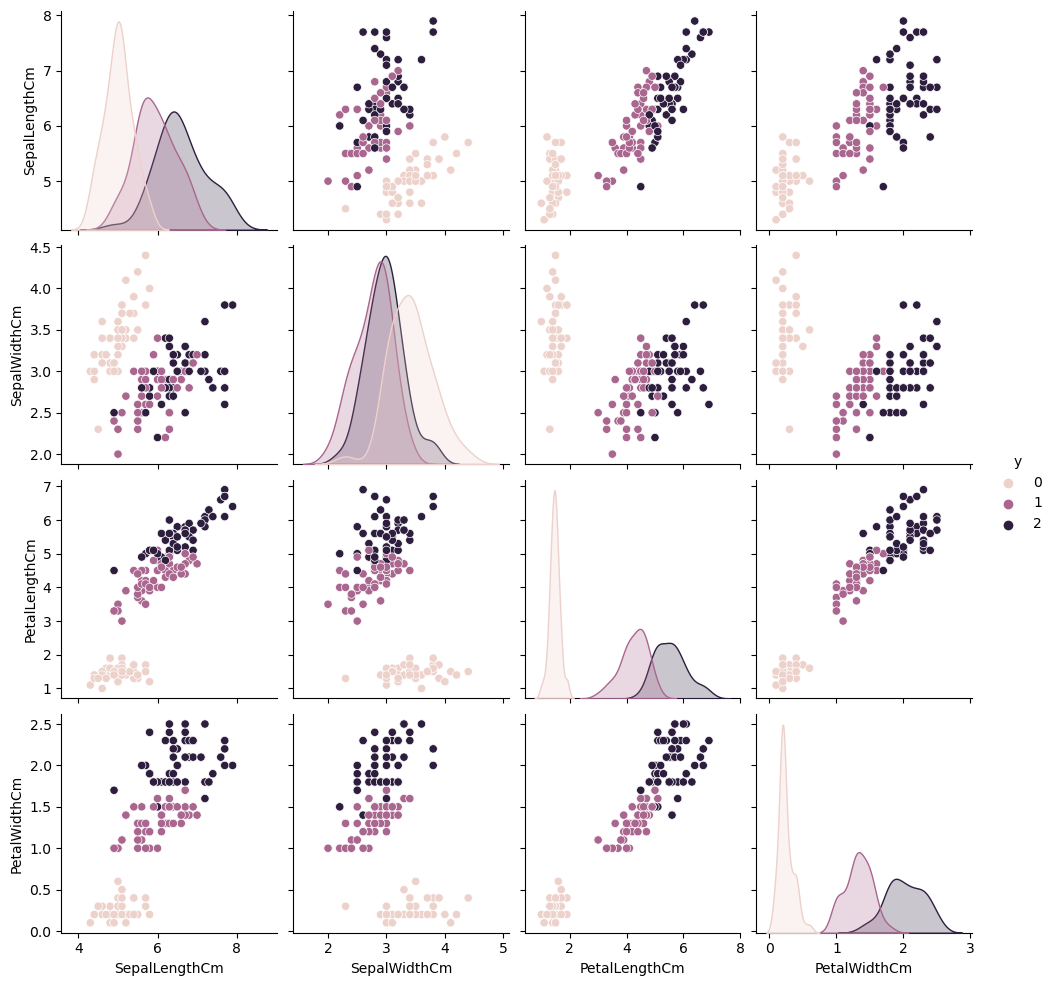

In [3]:
import seaborn as sns
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
sns.pairplot(df, hue="y")

In [4]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [5]:
from sklearn.preprocessing import StandardScaler
import torch

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

## Model Build

In [6]:
import torch.nn.functional as F


class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden1, n_hidden2, n_output):
        super(Net, self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden1)
        self.hidden2 = torch.nn.Linear(n_hidden1, n_hidden2)
        self.predict = torch.nn.Linear(n_hidden2, n_output)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.softmax(self.hidden2(x))
        x = self.predict(x)
        return x

In [7]:
net = Net(4, 20, 10, 3)
lr = 0.01

In [8]:
def train(epochs, lr, net=net, X_train=X_train, y_train=y_train):
    loss_func = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)
    for epoch in range(epochs):
        y_pred = net(X_train)
        loss = loss_func(y_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"epoch: {epoch:2}  loss: {loss.item():10.8f}")
    return loss.item()

In [9]:
train(200, lr)

epoch:  0  loss: 1.12531888
epoch: 100  loss: 1.07304072


0.8956484198570251

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def perform(net=net, X_test=X_test, y_test=y_test):
    with torch.no_grad():
        res = net(X_test)
        _, y_pred = torch.max(res, 1)
        print("prediction accuracy", accuracy_score(y_test, y_pred))
        print("precision", precision_score(y_test, y_pred, average="weighted"))
        print("recall", recall_score(y_test, y_pred, average="weighted"))
        print("f1_score", f1_score(y_test, y_pred, average="weighted"))

In [11]:
perform()

prediction accuracy 0.6333333333333333
precision 0.4789473684210526
recall 0.6333333333333333
f1_score 0.5246913580246914


## Hyperparameter Search

In [12]:
lrs = [0.1, 0.01, 0.05]
n_hiddens = [10, 20, 30]
epochs = 500
best_loss = float("inf")
best_params = {}
for lr in lrs:
    for n_hidden1 in n_hiddens:
        for n_hidden2 in n_hiddens:
            net = Net(n_feature=4, n_hidden1=n_hidden1, n_hidden2=n_hidden2, n_output=3)
            print(
                f"Training with learning rate: {lr}, n_hidden1: {n_hidden1},n_hidden2: {n_hidden2}"
            )
            final_loss = train(epochs, lr, net, X_train, y_train)

            if final_loss < best_loss:
                best_loss = final_loss
                best_params = {
                    "learning_rate": lr,
                    "n_hidden1": n_hidden1,
                    "n_hidden2": n_hidden2,
                }
                print(f"New best loss: {best_loss:.8f}")

print(f"Best parameters found: {best_params} with loss: {best_loss:.8f}")

Training with learning rate: 0.1, n_hidden1: 10,n_hidden2: 10
epoch:  0  loss: 1.09342694
epoch: 100  loss: 0.19591378
epoch: 200  loss: 0.06565936
epoch: 300  loss: 0.05256366
epoch: 400  loss: 0.04715447
New best loss: 0.04446794
Training with learning rate: 0.1, n_hidden1: 10,n_hidden2: 20
epoch:  0  loss: 1.10337985
epoch: 100  loss: 0.28480309
epoch: 200  loss: 0.07777768
epoch: 300  loss: 0.06022982
epoch: 400  loss: 0.05433667
Training with learning rate: 0.1, n_hidden1: 10,n_hidden2: 30
epoch:  0  loss: 1.09962058
epoch: 100  loss: 0.42142108
epoch: 200  loss: 0.07147727
epoch: 300  loss: 0.05852656
epoch: 400  loss: 0.05581794
Training with learning rate: 0.1, n_hidden1: 20,n_hidden2: 10
epoch:  0  loss: 1.11147463
epoch: 100  loss: 0.12909032
epoch: 200  loss: 0.05387000
epoch: 300  loss: 0.04595075
epoch: 400  loss: 0.03843339
New best loss: 0.02578169
Training with learning rate: 0.1, n_hidden1: 20,n_hidden2: 20
epoch:  0  loss: 1.10304761
epoch: 100  loss: 0.30610722
epoch